# scEU-seq organoid

This tutorial uses the intestine organoid data from Battich, et al (2020). This tutorial is the second one of the two tutorials for demonstrating how dynamo can use used to analyze the scEU-seq data. Please refer the cell cycle tutorial for details on how to analyze the cell cycle dataset.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import dynamo as dyn
import anndata
import pandas as pd
import numpy as np
import scipy.sparse

from anndata import AnnData
from scipy.sparse import csr_matrix

dyn.get_all_dependencies_version()

package dynamo-release umap-learn anndata cvxopt hdbscan loompy matplotlib  \
version         0.95.2      0.4.6   0.7.4  1.2.3  0.8.26  3.0.6      3.3.0   

package   numba   numpy pandas pynndescent python-igraph scikit-learn  scipy  \
version  0.51.0  1.19.1  1.1.1       0.4.8         0.8.2       0.23.2  1.5.2   

package seaborn setuptools statsmodels    tqdm  trimap numdifftools colorcet  
version   0.9.0     49.6.0      0.11.1  4.48.2  1.0.12       0.9.39    2.0.2

## Load data

In [2]:
organoid = dyn.read('/Users/xqiu/Dropbox (Personal)/dynamo/dont_remove/organoid.h5ad')

In [3]:
# mapping:
cell_mapper = {
    '1': 'Enterocytes',
    '2': 'Enterocytes',
    '3': 'Enteroendocrine',
    '4': 'Enteroendocrine progenitor',
    '5': 'Tuft cells',
    '6': 'TA cells',
    '7': 'TA cells',
    '8': 'Stem cells',
    '9': 'Paneth cells',
    '10': 'Goblet cells',
    '11': 'Stem cells',
 }

organoid.obs['cell_type'] = organoid.obs.som_cluster_id.map(cell_mapper).astype('str')


## typical dynamo analysis workflow


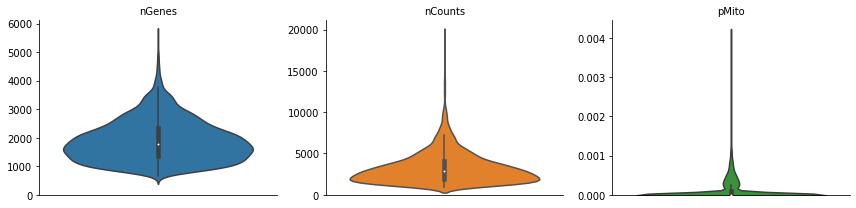

In [4]:
dyn.pl.basic_stats(organoid)

In [5]:
organoid

AnnData object with n_obs × n_vars = 3831 × 9157
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito'
    var: 'ID', 'NAME'
    layers: 'sl', 'su', 'ul', 'uu'

In [6]:
organoid.obs

well_id batch_id treatment_id      log10_gfp  rotated_umap1  \
1         14       01    Pulse_120  12.8929281522  23.0662174225   
2         15       01    Pulse_120  5.85486775252   25.710735321   
3         16       01    Pulse_120  7.45690471634  26.7709560394   
4         17       01    Pulse_120  94.2814535609  21.2927913666   
5         21       01    Pulse_120  47.1412266395  19.9096126556   
...      ...      ...          ...            ...            ...   
3827     378       12    Pulse_120   32.496816667  20.7663478851   
3828     379       12    Pulse_120  78.1198193763  20.1073760986   
3829     380       12    Pulse_120   53.249846399  20.1618804932   
3830     381       12   Pulse_dmso  16.7070737849  15.4272613525   
3831     383       12   Pulse_dmso  93.3716092195  21.5953540802   

        rotated_umap2 som_cluster_id monocle_branch_id monocle_pseudotime  \
1      -3.47039175034              6                 2      6.08688834859   
2      -1.31835341454              2                 2      9.14740876358   
3      -1.06682777405              2                 2      9.69134627386   
4     0.0159659013152             11                 2       4.2635104705   
5      0.884054124355             11                 1      2.62248093423   
...               ...            ...               ...                ...   
3827   -3.72811675072              8                 3      7.32939908351   
3828   -2.65023303032              8                 3      5.10436147713   
3829   -3.83158016205              8                 3      6.43742448317   
3830   -2.15779066086             10                 1     0.657880511889   
3831   -3.90664196014              6                 2      4.81727202212   

     exp_type  time     cell_type  nGenes  nCounts  pMito  
1       Pulse   120      TA cells    1054   1426.0    0.0  
2       Pulse   120   Enterocytes    1900   3712.0    0.0  
3       Pulse   120   Enterocytes    2547   6969.0    0.0  
4       Pulse   120    Stem cells    1004   1263.0    0.0  
5       Pulse   120    Stem cells     927   1144.0    0.0  
...       ...   ...           ...     ...      ...    ...  
3827    Pulse   120    Stem cells    2268   3918.0    0.0  
3828    Pulse   120    Stem cells    2131   3619.0    0.0  
3829    Pulse   120    Stem cells    2141   3603.0    0.0  
3830    Pulse  dmso  Goblet cells    1158   1683.0    0.0  
3831    Pulse  dmso      TA cells    1374   1838.0    0.0  

[3831 rows x 15 columns]

In [7]:
organoid.obs.groupby(['exp_type', 'time']).agg('count')

well_id  batch_id  treatment_id  log10_gfp  rotated_umap1  \
exp_type time                                                              
Chase    0       660.0     660.0         660.0      660.0          660.0   
         45      821.0     821.0         821.0      821.0          821.0   
         120       NaN       NaN           NaN        NaN            NaN   
         360     646.0     646.0         646.0      646.0          646.0   
         dmso      NaN       NaN           NaN        NaN            NaN   
Pulse    0         NaN       NaN           NaN        NaN            NaN   
         45        NaN       NaN           NaN        NaN            NaN   
         120    1373.0    1373.0        1373.0     1373.0         1373.0   
         360       NaN       NaN           NaN        NaN            NaN   
         dmso    331.0     331.0         331.0      331.0          331.0   

               rotated_umap2  som_cluster_id  monocle_branch_id  \
exp_type time                                                     
Chase    0             660.0           660.0              660.0   
         45            821.0           821.0              821.0   
         120             NaN             NaN                NaN   
         360           646.0           646.0              646.0   
         dmso            NaN             NaN                NaN   
Pulse    0               NaN             NaN                NaN   
         45              NaN             NaN                NaN   
         120          1373.0          1373.0             1373.0   
         360             NaN             NaN                NaN   
         dmso          331.0           331.0              331.0   

               monocle_pseudotime  cell_type  nGenes  nCounts   pMito  
exp_type time                                                          
Chase    0                  660.0      660.0   660.0    660.0   660.0  
         45                 821.0      821.0   821.0    821.0   821.0  
         120                  NaN        NaN     NaN      NaN     NaN  
         360                646.0      646.0   646.0    646.0   646.0  
         dmso                 NaN        NaN     NaN      NaN     NaN  
Pulse    0                    NaN        NaN     NaN      NaN     NaN  
         45                   NaN        NaN     NaN      NaN     NaN  
         120               1373.0     1373.0  1373.0   1373.0  1373.0  
         360                  NaN        NaN     NaN      NaN     NaN  
         dmso               331.0      331.0   331.0    331.0   331.0

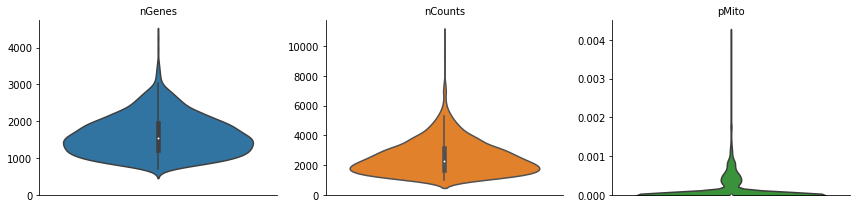

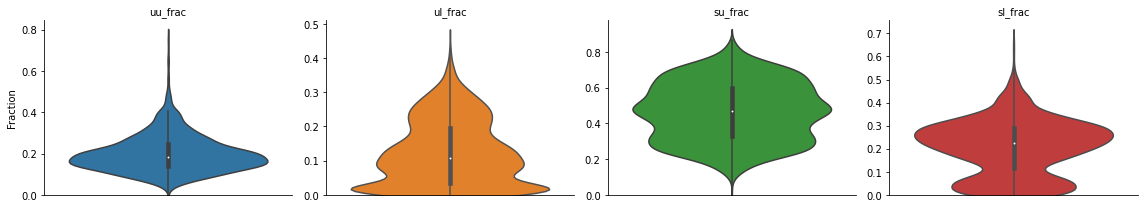

In [8]:
adata = organoid.copy()
adata.obs.time = adata.obs.time.astype('str')
adata.obs.loc[adata.obs['time'] == 'dmso', 'time'] = -1
adata.obs['time'] = adata.obs['time'].astype(float)
adata = adata[adata.obs.time != -1, :]
adata = adata[adata.obs.exp_type == 'Pulse', :]
adata.layers['new'], adata.layers['total'] = adata.layers['ul'] + adata.layers['sl'], adata.layers['su'] + adata.layers['sl'] + adata.layers['uu'] + adata.layers['ul']
del adata.layers['uu'], adata.layers['ul'], adata.layers['su'], adata.layers['sl']
adata = dyn.pp.recipe_monocle(adata, n_top_genes=1000, total_layers=False)
dyn.pl.basic_stats(adata)
dyn.pl.show_fraction(organoid)

In [9]:
adata.obs.time = adata.obs.time/60

In [10]:
adata.obs.time  = adata.obs.time.astype('float')
dyn.tl.dynamics(adata, model='deterministic', tkey='time', assumption_mRNA='ss')

dyn.tl.reduceDimension(adata)

estimating gamma: 100%|██████████| 1000/1000 [00:15<00:00, 65.18it/s]


AnnData object with n_obs × n_vars = 1373 × 9157
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'Size_Factor', 'initial_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'ID', 'NAME', 'pass_basic_filter', 'score', 'log_m', 'log_cv', 'use_for_pca', 'ntr', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_dynamics'
    uns: 'velocyto_SVR', 'pp_norm_method', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit'
    obsm: 'X_pca', 'X', 'cell_cycle_scores', 'X_umap'
    varm: 'alpha'
    layers: 'new', 'total', 'X_total'

In [11]:
# dyn.tl.cell_velocities(adata)
dyn.tl.cell_velocities(adata, ekey='M_t', vkey='velocity_T', enforce=True)
# dyn.tl.cell_velocities(adata, ekey='M_s', vkey='velocity_S', enforce=True)


calculating transition matrix via pearson kernel with sqrt transform.: 100%|██████████| 1373/1373 [00:08<00:00, 160.25it/s]
projecting velocity vector to low dimensional embedding...: 100%|██████████| 1373/1373 [00:00<00:00, 3967.89it/s]


AnnData object with n_obs × n_vars = 1373 × 9157
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'Size_Factor', 'initial_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'ID', 'NAME', 'pass_basic_filter', 'score', 'log_m', 'log_cv', 'use_for_pca', 'ntr', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_dynamics', 'use_for_transition'
    uns: 'velocyto_SVR', 'pp_norm_method', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap'
    obsm: 'X_pca', 'X', 'cell_cycle_scores', 'X_umap', 'velocity_

In [12]:
adata.obsm['X_umap_ori'] = adata.obs.loc[:, ['rotated_umap1', 'rotated_umap2']].values.astype(float)

## Visualize time-resolved vector flow learned with dynamo 

projecting velocity vector to low dimensional embedding...:  63%|██████▎   | 865/1373 [00:00<00:00, 4325.98it/s]

Using existing pearson_transition_matrix found in .obsp.


projecting velocity vector to low dimensional embedding...: 100%|██████████| 1373/1373 [00:00<00:00, 4246.74it/s]


<Figure size 600x400 with 0 Axes>

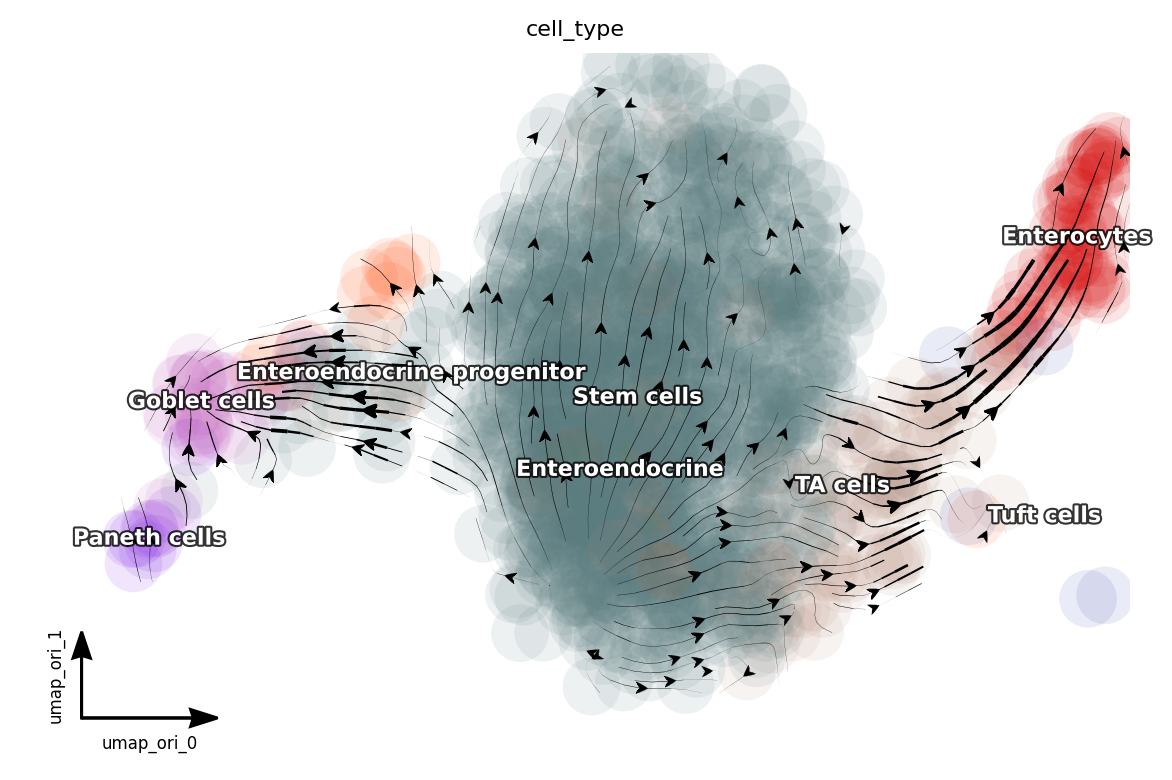

In [13]:
dyn.tl.cell_velocities(adata, basis='umap_ori')

dyn.pl.streamline_plot(adata, color='cell_type', basis='umap_ori')


<Figure size 600x400 with 0 Axes>

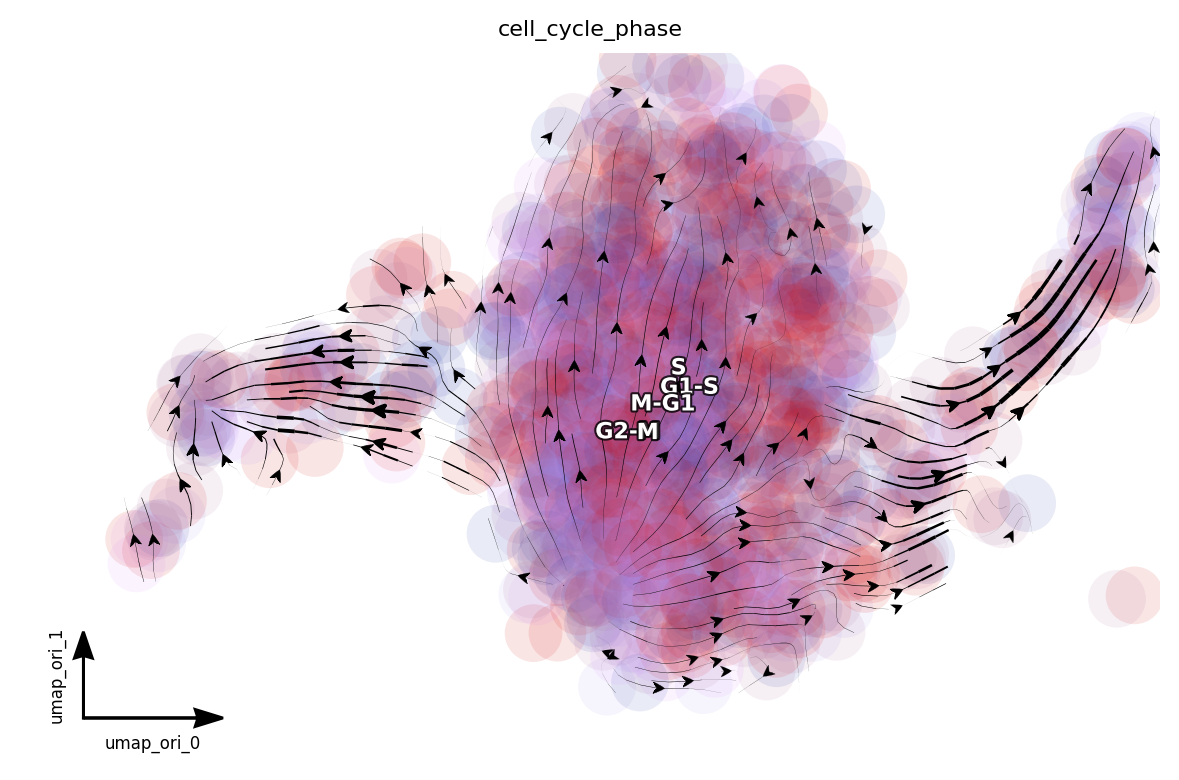

In [14]:
dyn.pl.streamline_plot(adata, color='cell_cycle_phase', basis='umap_ori')


In [15]:
adata.var_names[adata.var.use_for_transition][:5]

Index(['Cdc45', 'Brat1', 'Ccnd2', 'Ckmt1', 'Pdgfb'], dtype='object')

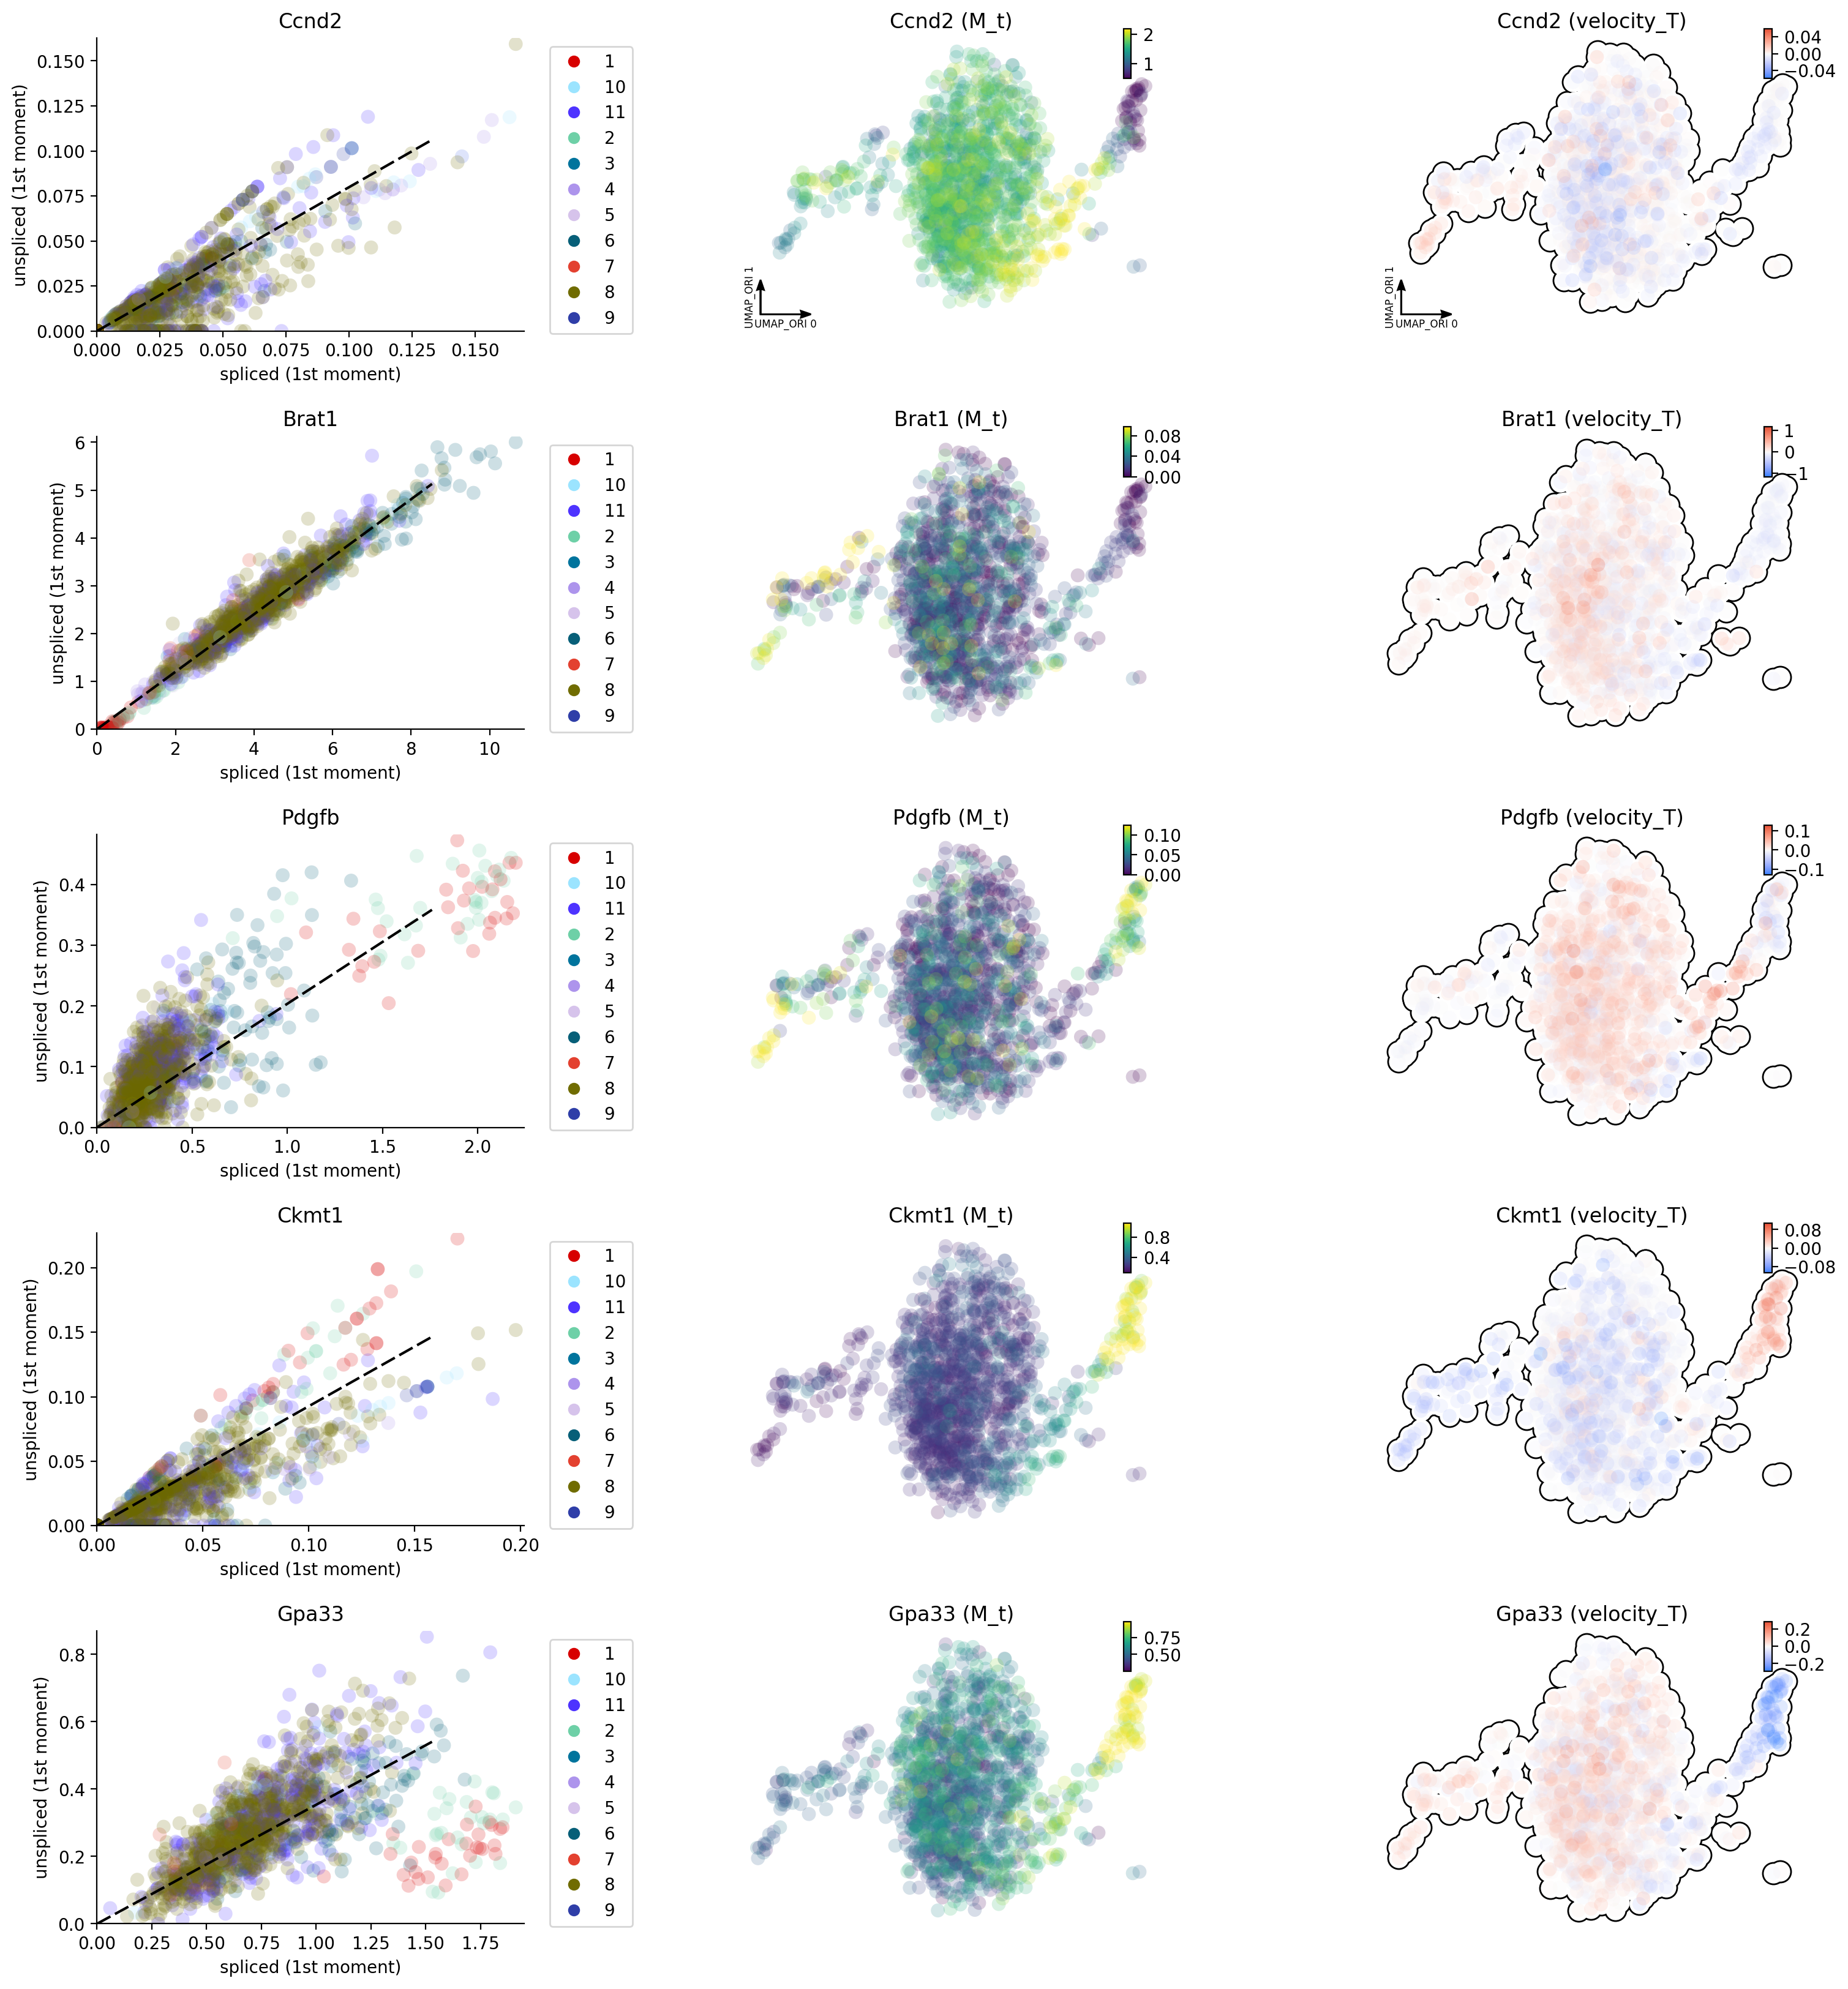

In [16]:
dyn.pl.phase_portraits(adata, genes=['Brat1', 'Ccnd2', 'Ckmt1', 'Pdgfb', 'Gpa33'],
                       color='som_cluster_id', basis='umap_ori')


## Animate intestine organoid differentiation

In [17]:
dyn.vf.VectorField(adata, basis='umap_ori')


AnnData object with n_obs × n_vars = 1373 × 9157
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'Size_Factor', 'initial_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'ID', 'NAME', 'pass_basic_filter', 'score', 'log_m', 'log_cv', 'use_for_pca', 'ntr', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_dynamics', 'use_for_transition'
    uns: 'velocyto_SVR', 'pp_norm_method', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap', 'grid_velocity_umap_ori', 'VecFld_umap_ori', 'VecFld'
    obsm: 

In [18]:
progenitor = adata.obs_names[adata.obs.cell_type == 'Stem cells']
len(progenitor)

1146

In [19]:
np.random.seed(19491001)

from matplotlib import animation
info_genes = adata.var_names[adata.var.use_for_transition]
dyn.pd.fate(adata, basis='umap_ori', init_cells=progenitor[:100], interpolation_num=100,  direction='forward',
   inverse_transform=False, average=False)


uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 283.47it/s]


AnnData object with n_obs × n_vars = 1373 × 9157
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'Size_Factor', 'initial_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'ID', 'NAME', 'pass_basic_filter', 'score', 'log_m', 'log_cv', 'use_for_pca', 'ntr', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_dynamics', 'use_for_transition'
    uns: 'velocyto_SVR', 'pp_norm_method', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap', 'grid_velocity_umap_ori', 'VecFld_umap_ori', 'VecFld', 'fate_uma

In [20]:
%%capture
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
ax = dyn.pl.topography(adata, basis='umap_ori', color='cell_type', ax=ax, save_show_or_return='return',  figsize=(24, 24))
ax.set_aspect(0.8)


In [21]:
%%capture
adata.obs['time'] = adata.obs.time.astype('float')
instance = dyn.mv.StreamFuncAnim(adata=adata, basis='umap_ori', color='cell_type', ax=ax)